# Описание проекта

Подготовим прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error, make_scorer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

Посмотрим на наши данные.

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train.csv', index_col='date')
test = pd.read_csv('/datasets/gold_recovery_test.csv', index_col='date')
full = pd.read_csv('/datasets/gold_recovery_full.csv', index_col='date')
train.head(5)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant                      15598 non-null float64
primary_cleaner.i

Видим, что в наших данных довольно много пропусков. Отбросим их и вернемся к ним позднее.

In [4]:
train1 = train.dropna()

In [5]:
train1['rougher.output.recovery'].mean()

82.7418884610155

Вручную подсчитаем эффективность обогащения на обучающей выборке для признака rougher.output.recovery

In [6]:
train1['numerator'] = train1['rougher.output.concentrate_au'] * (train1['rougher.input.feed_au'] - train1['rougher.output.tail_au'])
train1['denominator'] = train1['rougher.input.feed_au'] * (train1['rougher.output.concentrate_au'] - train1['rougher.output.tail_au'])
train1['recovery'] = (train1['numerator'] / train1['denominator']) * 100

Найдём MAE между нашими расчётами и фактическими значением признака.

In [7]:
mae = mean_absolute_error(train1['rougher.output.recovery'], train1['recovery'])
mae

9.555596961987514e-15

#### Вывод

Получившееся число очень мало, значит, эффективность обогащения в таблице подсчитана правильно.

Проанализируем признаки, недоступные в тестовой выборке.

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.input.feed_ag                         584

В выборке test отсутствуют признаки с параметром 'output' (для всех этапов - rougher, primary_cleaner, secondary_cleaner, final), а также блок признаков 'rougher.calculation'. Все эти признаки характеризуют результаты этапов флотации/очистки.

Вернёмся к нашим пропускам. Заполним их предыдущим значением для каждого признака.

In [9]:
train = train.fillna(method='ffill')
test = test.fillna(method='ffill')
full = full.fillna(method='ffill')

# 2. Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

Начнём с золота.

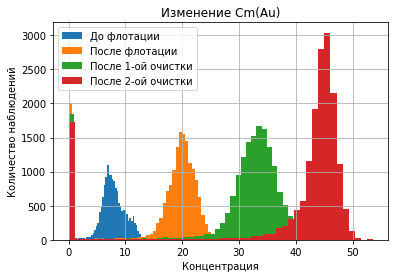

In [10]:
train['rougher.input.feed_au'].hist(bins=50, label='До флотации')
train['rougher.output.concentrate_au'].hist(bins=50, label='После флотации')
train['primary_cleaner.output.concentrate_au'].hist(bins=50, label='После 1-ой очистки')
train['final.output.concentrate_au'].hist(bins=50, label='После 2-ой очистки')
plt.xlabel('Концентрация')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.title('Изменение Cm(Au)')
plt.show()

#### Вывод

С каждым этапом концентрация золота растёт.

Теперь - серебро.

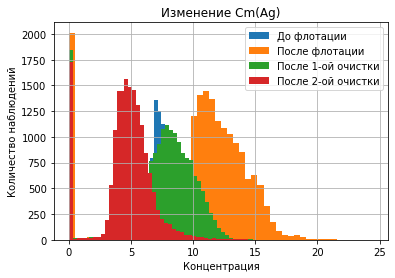

In [11]:
train['rougher.input.feed_ag'].hist(bins=50, label='До флотации')
train['rougher.output.concentrate_ag'].hist(bins=50, label='После флотации')
train['primary_cleaner.output.concentrate_ag'].hist(bins=50, label='После 1-ой очистки')
train['final.output.concentrate_ag'].hist(bins=50, label='После 2-ой очистки')
plt.xlabel('Концентрация')
plt.ylabel('Количество наблюдений')
plt.title('Изменение Cm(Ag)')
plt.legend()
plt.show()

#### Вывод

После флотации концентрация серебра становится больше, чем в исходном сырье, но затем по мере очистки она падает.

Теперь - свинец.

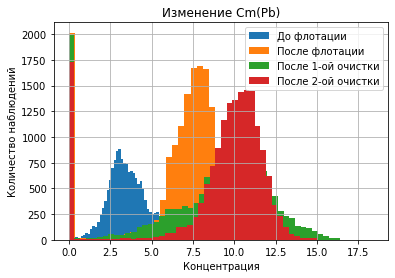

In [12]:
train['rougher.input.feed_pb'].hist(bins=50, label='До флотации')
train['rougher.output.concentrate_pb'].hist(bins=50, label='После флотации')
train['primary_cleaner.output.concentrate_pb'].hist(bins=50, label='После 1-ой очистки')
train['final.output.concentrate_pb'].hist(bins=50, label='После 2-ой очистки')
plt.xlabel('Концентрация')
plt.ylabel('Количество наблюдений')
plt.title('Изменение Cm(Pb)')
plt.legend()
plt.show()

#### Вывод

После мере очистки концентрация свинца растет, хотя последний этап очистки ее почти не меняет.

Теперь сравним распределения размеров гранул сырья на обучающей и тестовой выборках (на двух стадиях).

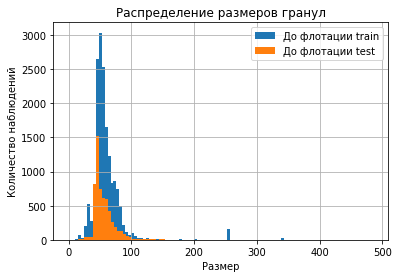

In [13]:
train['rougher.input.feed_size'].hist(bins=100, label='До флотации train')
test['rougher.input.feed_size'].hist(bins=100, label='До флотации test')
plt.xlabel('Размер')
plt.ylabel('Количество наблюдений')
plt.title('Распределение размеров гранул')
plt.legend()
plt.show()

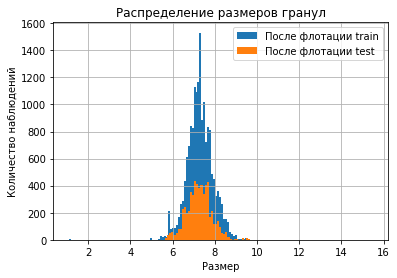

In [14]:
train['primary_cleaner.input.feed_size'].hist(bins=100, label='После флотации train')
test['primary_cleaner.input.feed_size'].hist(bins=100, label='После флотации test')
plt.xlabel('Размер')
plt.ylabel('Количество наблюдений')
plt.title('Распределение размеров гранул')
plt.legend()
plt.show()

#### Вывод

Видим, что распределения, особенно после флотации, в целом совпадают.

Теперь исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

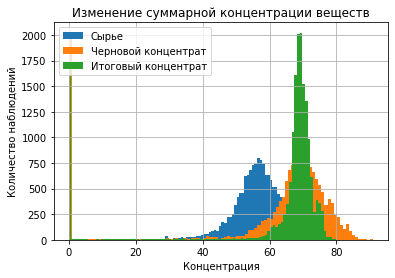

In [15]:
train['total_raw'] = train['rougher.input.feed_ag']+train['rougher.input.feed_au']+train['rougher.input.feed_pb']+train['rougher.input.feed_sol']
train['total_rougher'] = train['rougher.output.concentrate_ag']+train['rougher.output.concentrate_au']+train['rougher.output.concentrate_pb']+train['rougher.output.concentrate_sol']
train['total_final'] = train['final.output.concentrate_ag']+train['final.output.concentrate_au']+train['final.output.concentrate_pb']+train['final.output.concentrate_sol']

train['total_raw'].hist(bins=100, label='Сырье')
train['total_rougher'].hist(bins=100, label='Черновой концентрат')
train['total_final'].hist(bins=100, label='Итоговый концентрат')
plt.xlabel('Концентрация')
plt.ylabel('Количество наблюдений')
plt.title('Изменение суммарной концентрации веществ')
plt.legend()
plt.show()

Уберем из выборок нулевые значения, которые мы заметили на гистограммах. Ненулевые выбросы оставим, чтобы наша модель обучалась на всех доступных данных.

In [16]:
for i in ['rougher.input.feed_ag', 'rougher.input.feed_au', 'rougher.input.feed_pb', 'rougher.input.feed_sol',
         'rougher.output.concentrate_ag', 'rougher.output.concentrate_au', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
         'final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb', 'final.output.concentrate_sol']:
    train = train[train[i]>1]

for i in ['rougher.input.feed_ag', 'rougher.input.feed_au', 'rougher.input.feed_pb', 'rougher.input.feed_sol']:
    test = test[test[i]>1]

# 3. Модель

Напишем функции для вычисления итоговой sMAPE: сначала для константной модели, потом для предсказывающей модели.

In [17]:
def const_smape(const0, const1, y_true):
    sum0 = 0
    sum1 = 0
    for i in range(len(y_true)):
        term0 = abs(y_true[i][0]-const0)/((abs(y_true[i][0])+abs(const0))/2)
        sum0 += term0
        
        term1 = abs(y_true[i][1]-const1)/((abs(y_true[i][1])+abs(const1))/2)
        sum1 += term1
        
    smape_rough = (sum0 / len(y_true))*100
    smape_fin = (sum1 / len(y_true))*100
    
    res_smape = 0.25 * smape_rough + 0.75 * smape_fin
    return res_smape   

In [18]:
def res_smape(y_pred, y_true):
    sum0 = 0
    sum1 = 0
    for i in range(len(y_pred)):
        term0 = abs(y_true[i][0]-y_pred[i][0])/((abs(y_true[i][0])+abs(y_pred[i][0]))/2)
        sum0 += term0
        
        term1 = abs(y_true[i][1]-y_pred[i][1])/((abs(y_true[i][1])+abs(y_pred[i][1]))/2)
        sum1 += term1
        
    smape_rough = (sum0 / len(y_pred))*100
    smape_fin = (sum1 / len(y_pred))*100
    
    res_smape = 0.25 * smape_rough + 0.75 * smape_fin
    return res_smape   

In [19]:
# оставим в обучающей выборке только те признаки, которые есть в тестовой
our_columns = test.columns
X_train = train[our_columns]
y_train = train[['rougher.output.recovery', 'final.output.recovery']]

X_test = test

test_with_target = full.loc[test.index].reset_index(drop=True)

y_test = test_with_target[['rougher.output.recovery', 'final.output.recovery']]
y_test_array = y_test.to_numpy()

#стандартизируем данные
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Подсчитаем точность константной модели.

In [20]:
const_smape(train['rougher.output.recovery'].median(), train['final.output.recovery'].median(), y_test_array)

10.132400113702523

Обучим модель линейной регрессии.

In [21]:
model1 = LinearRegression()

model1.fit(X_train, y_train)
predictions1 = model1.predict(X_test)

print('Оценка кросс-валидацией: ', cross_val_score(model1, X_train, y_train, cv=5).mean())
print('Итоговая sMAPE - ', res_smape(predictions1, y_test_array))

Оценка кросс-валидацией:  -0.2742596849214898
Итоговая sMAPE -  10.281662190902868


Обучим модель случайного леса.

In [22]:
param_forest = {'max_depth': range(5, 51, 5), 'min_samples_split': range(2, 10), 'min_samples_leaf': range(1, 10)}
model2 = RandomizedSearchCV(estimator = RandomForestRegressor(random_state=1), n_iter=5, param_distributions = param_forest, random_state=1)
model2.fit(X_train, y_train)
best_model = model2.best_estimator_
predictions2 = best_model.predict(X_test)

print('Оценка кросс-валидацией: ', cross_val_score(best_model, X_train, y_train, cv=5).mean())
print('Итоговая sMAPE - ', res_smape(predictions2, y_test_array))

Оценка кросс-валидацией:  -0.08153280704475743
Итоговая sMAPE -  10.077110755803393


Обучим модель Lasso

In [23]:
model3 = Lasso()

model3.fit(X_train, y_train)
predictions3 = model3.predict(X_test)

print('Оценка кросс-валидацией: ', cross_val_score(model3, X_train, y_train, cv=5).mean())
print('Итоговая sMAPE - ', res_smape(predictions3, y_test_array))

Оценка кросс-валидацией:  -0.026986359193267584
Итоговая sMAPE -  9.167879021201303


#### Вывод

Мы видим, что получившееся значение sMAPE довольно велико, значит, полученные модели не очень хорошо справились с задачей. Тем не менее, модель Lasso и модель RandomForestRegressor показали себя немного лучше, чем константная модель.

### Общие выводы

В ходе работы над проектом мы:

- проверили точность подсчёта показателя recovery
- избавились от пропусков в наших данных
- изучили, какие признаки отсутствуют в тестовой выборке
- изучили, как меняется концентрация веществ на разных стадиях технологического процесса и постарались убрать значения-выбросы
- создали функцию для подсчёта итоговой sMAPE
- построили три модели, предсказывающие переменные rougher.output.recovery и final.output.recovery для тестовой выборки, и сравнили их с результатами константной модели (наши модели работают немного лучше)
- посчитали, насколько сильно отличаются предсказания от фактических значений при помощи sMAPE